### Corona data from corona data scraper 

[Corona Data Scraper](https://coronadatascraper.com/#home)

In [1]:
import numpy as np
import pandas as pd

In [2]:
rawtimeseries = pd.read_csv('https://coronadatascraper.com/timeseries.csv', parse_dates=['date'])

display('Timeseries:')
display(rawtimeseries.head())

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'Timeseries:'

,name,level,city,county,state,country,population,lat,long,url,...,recovered,active,tested,hospitalized,hospitalized_current,discharged,icu,icu_current,growthFactor,date
0,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22
1,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-23
2,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-24
3,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-25
4,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-26


### USA county-level data

In [3]:
USA = rawtimeseries[(rawtimeseries.country == 'United States') & (rawtimeseries.level == 'county')]

### NY for proof of concept

In [4]:
NY = USA[USA.state == 'New York']
len(NY)

6138

In [5]:
NY['county'].nunique()

58

In [6]:
NY['county'].value_counts()

New York County        121
Westchester County     120
Nassau County          118
Rockland County        117
Saratoga County        116
Suffolk County         115
Ulster County          115
Monroe County          112
Albany County          111
Delaware County        111
Dutchess County        111
Herkimer County        111
Orange County          111
Schenectady County     110
Broome County          110
Tompkins County        109
Erie County            109
Tioga County           109
Montgomery County      108
Greene County          108
Putnam County          108
Allegany County        107
Onondaga County        107
Ontario County         107
Clinton County         106
Sullivan County        106
Oneida County          106
Essex County           106
Rensselaer County      106
Wyoming County         106
Chenango County        105
Genesee County         105
Livingston County      105
Hamilton County        105
Washington County      105
Warren County          105
Jefferson County       105
N

In [7]:
# no zeros in this dataset which means that I cannot tell between zero and not recorded
sum(NY['deaths'] == 0)

0

In [ ]:
Rockland = NY[NY.county.isin(['Rockland County','Wyoming County'])]

In [ ]:
len(Rockland)

In [ ]:
Rockland.dtypes

In [8]:
# f = Rockland[['date','county','cases','deaths']].set_index(['county','date'])
f=NY[['date','county','cases','deaths']].set_index(['county','date'])

In [9]:
f

cases  deaths
county        date                     
Albany County 2020-03-12    2.0     NaN
              2020-03-13    2.0     NaN
              2020-03-14    5.0     NaN
              2020-03-15   11.0     NaN
              2020-03-16   12.0     NaN
...                         ...     ...
Yates County  2020-06-26   45.0     6.0
              2020-06-27   45.0     6.0
              2020-06-28   45.0     6.0
              2020-06-29   46.0     6.0
              2020-06-30   46.0     6.0

[6138 rows x 2 columns]

### Data Cleaning

Notice all the data are cumulative since beginning of recording. So we will have to do first-differencing to get the actual number of deaths per day.

The daily cumulative numbers have some inaccuracies: 
1. Have missing data at the beginning and center of timeseries (see Wyoming County below). At the beginning these NAs are zero, in the center of a timeseries they cannot be zero.  
1. Have some cumulative numbers that drop from one day to the next (see Rockland County below).

We have to do the following
1. Roll up to weekly  
1. Clean up NAs 
1. Clean up drops in cumulative numbers

Probably easiest to roll up to the weekly numbers first (not really a rollup, simply take the value for every Sunday). This will aleviate some of the other issues. 

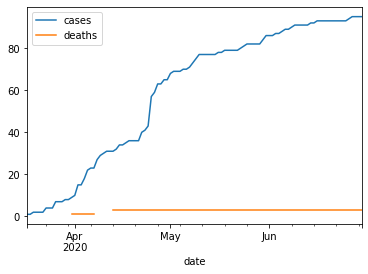

In [10]:
f.loc['Wyoming County',:].plot()

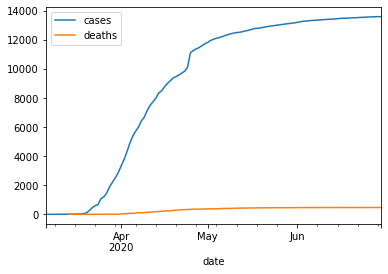

In [11]:
f.loc['Rockland County',:].plot()

#### Missing values 

There are two types of missing values that I want to treat differently: 
1. Missing values at the beginning of a time series 
2. Missing values within a time series

Wyoming County is a good example of both of these.

I will transform these as follows:
1. fill in with zero 
1. fill in with the most recent cumulative count (presumably the day before)

Because of the way the fillna code works, we are going to do these in the opposite order (start with #2).

In [22]:
# recreate df removing index
# f = Rockland[['date','county','cases','deaths']]
f=NY[['date','county','cases','deaths']]

In [13]:
f.head()

,date,county,cases,deaths
203038,2020-03-12,Albany County,2.0,NaN
203039,2020-03-13,Albany County,2.0,NaN
203040,2020-03-14,Albany County,5.0,NaN
203041,2020-03-15,Albany County,11.0,NaN
203042,2020-03-16,Albany County,12.0,NaN


In [23]:
pd.set_option('display.max_rows', None)

# this is step 2, fill with the prior day (or most recent day without NA)
f = f.groupby('county',as_index=False).fillna(method='ffill')

In [24]:
f[f.county == 'Wyoming County']

,date,county,cases,deaths
208980,2020-03-17,Wyoming County,1.0,NaN
208981,2020-03-18,Wyoming County,1.0,NaN
208982,2020-03-19,Wyoming County,2.0,NaN
208983,2020-03-20,Wyoming County,2.0,NaN
208984,2020-03-21,Wyoming County,2.0,NaN
208985,2020-03-22,Wyoming County,2.0,NaN
208986,2020-03-23,Wyoming County,4.0,NaN
208987,2020-03-24,Wyoming County,4.0,NaN
208988,2020-03-25,Wyoming County,4.0,NaN
208989,2020-03-26,Wyoming County,7.0,NaN


In [25]:
# this is step #1 fill remainder of NAs with zero (will always be at beginning of timeseries)
f.fillna(0.0,inplace=True)

In [32]:
f[f.county == 'Albany County']

,date,county,cases,deaths
203038,2020-03-12,Albany County,2.0,0.0
203039,2020-03-13,Albany County,2.0,0.0
203040,2020-03-14,Albany County,5.0,0.0
203041,2020-03-15,Albany County,11.0,0.0
203042,2020-03-16,Albany County,12.0,0.0
203043,2020-03-17,Albany County,23.0,0.0
203044,2020-03-18,Albany County,36.0,0.0
203045,2020-03-19,Albany County,43.0,0.0
203046,2020-03-20,Albany County,61.0,0.0
203047,2020-03-21,Albany County,88.0,0.0


#### Filter to sundays

Create a filter for all the sundays.  

In [38]:
# sundays = pd.date_range('2019-12-29', '2021-01-31', freq='W-SUN')
saturdays = pd.date_range('2019-12-28', '2021-01-30', freq='W-SAT')

In [41]:
# newf = f[f.date.isin(sundays)]
f = f[f.date.isin(saturdays)]

In [42]:
f

,date,county,cases,deaths
203040,2020-03-14,Albany County,5.0,0.0
203047,2020-03-21,Albany County,88.0,0.0
203054,2020-03-28,Albany County,195.0,1.0
203061,2020-04-04,Albany County,293.0,6.0
203068,2020-04-11,Albany County,446.0,16.0
203075,2020-04-18,Albany County,648.0,26.0
203082,2020-04-25,Albany County,899.0,43.0
203089,2020-05-02,Albany County,1238.0,60.0
203096,2020-05-09,Albany County,1416.0,107.0
203103,2020-05-16,Albany County,1572.0,127.0


### Calculate the weekly deaths by differing cumulative deaths

In [43]:
# calculate the weekly deaths
f['prev_value'] = f.groupby('county')['cases'].shift(1)
f['weekly_cases'] = f['cases']-f['prev_value']

f['prev_value'] = f.groupby('county')['deaths'].shift(1)
f['weekly_deaths'] = f['deaths']-f['prev_value']

In [44]:
f

,date,county,cases,deaths,prev_value,weekly_cases,weekly_deaths
203040,2020-03-14,Albany County,5.0,0.0,NaN,NaN,NaN
203047,2020-03-21,Albany County,88.0,0.0,0.0,83.0,0.0
203054,2020-03-28,Albany County,195.0,1.0,0.0,107.0,1.0
203061,2020-04-04,Albany County,293.0,6.0,1.0,98.0,5.0
203068,2020-04-11,Albany County,446.0,16.0,6.0,153.0,10.0
203075,2020-04-18,Albany County,648.0,26.0,16.0,202.0,10.0
203082,2020-04-25,Albany County,899.0,43.0,26.0,251.0,17.0
203089,2020-05-02,Albany County,1238.0,60.0,43.0,339.0,17.0
203096,2020-05-09,Albany County,1416.0,107.0,60.0,178.0,47.0
203103,2020-05-16,Albany County,1572.0,127.0,107.0,156.0,20.0


In [45]:
df_trend = f[['date','county','weekly_cases','weekly_deaths']].set_index(['county','date'])

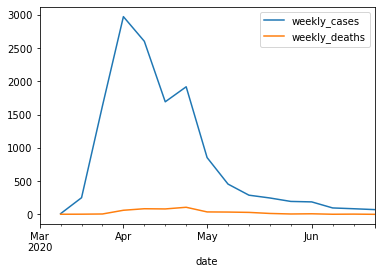

In [46]:
df_trend.loc['Rockland County',:].plot()

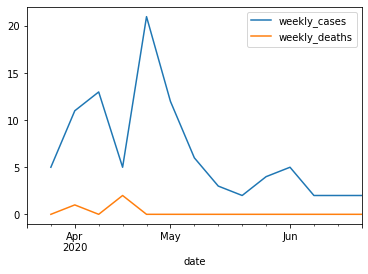

In [47]:
df_trend.loc['Wyoming County',:].plot()

### Week over week

In [48]:
df_trend['prev_value'] = df_trend.groupby('county')['weekly_cases'].shift(1)
df_trend['cases_wow'] = (df_trend['weekly_cases']-df_trend['prev_value'])/df_trend['prev_value']
df_trend.loc[np.isnan(df_trend['cases_wow']), 'cases_wow'] = 0.0
df_trend.loc[~np.isfinite(df_trend['cases_wow']), 'cases_wow'] = 100.0

df_trend['cases_wow2'] = pd.cut(df_trend['cases_wow'],bins=[-1,-0.5,-0.05,0.05,.5,1,99999],labels=['-100% to -50%','-50% to -5%','no change','5% to 50%','50% to 100%','100%+'])

In [49]:
# need to move this into a function to rerun...
df_trend['prev_value'] = df_trend.groupby('county')['weekly_deaths'].shift(1)
df_trend['deaths_wow'] = (df_trend['weekly_deaths']-df_trend['prev_value'])/df_trend['prev_value']
# 0/0 will result in NaNs; we'll define those as 0% growth
df_trend.loc[np.isnan(df_trend['deaths_wow']), 'deaths_wow'] = 0.0
# number/0 will result in Inf. we'll define these as 100% growth
df_trend.loc[~np.isfinite(df_trend['deaths_wow']), 'deaths_wow'] = 110.0

df_trend['deaths_wow2'] = pd.cut(df_trend['deaths_wow'],bins=[-1,-0.5,-0.05,0.05,.5,1,99999],labels=['-100% to -50%','-50% to -5%','no change','5% to 50%','50% to 100%','100%+'])

In [50]:
df_trend

weekly_cases  weekly_deaths  prev_value  \
county              date                                                  
Albany County       2020-03-14           NaN            NaN         NaN   
                    2020-03-21          83.0            0.0         NaN   
                    2020-03-28         107.0            1.0         0.0   
                    2020-04-04          98.0            5.0         1.0   
                    2020-04-11         153.0           10.0         5.0   
                    2020-04-18         202.0           10.0        10.0   
                    2020-04-25         251.0           17.0        10.0   
                    2020-05-02         339.0           17.0        17.0   
                    2020-05-09         178.0           47.0        17.0   
                    2020-05-16         156.0           20.0        47.0   
                    2020-05-23         198.0           11.0        20.0   
                    2020-05-30          73.0            4.0        11.0   
                    2020-06-06         110.0            4.0         4.0   
                    2020-06-13          63.0            6.0         4.0   
                    2020-06-20          37.0            5.0         6.0   
                    2020-06-27          38.0            2.0         5.0   
Allegany County     2020-03-21           NaN            NaN         NaN   
                    2020-03-28           0.0            0.0         NaN   
                    2020-04-04          14.0            1.0         0.0   
                    2020-04-11          10.0            0.0         1.0   
                    2020-04-18           4.0            0.0         0.0   
                    2020-04-25           5.0            0.0         0.0   
                    2020-05-02           0.0            0.0         0.0   
                    2020-05-09           0.0            0.0         0.0   
                    2020-05-16           9.0            0.0         0.0   
                    2020-05-23           0.0            0.0         0.0   
                    2020-05-30           1.0            0.0         0.0   
                    2020-06-06           6.0            0.0         0.0   
                    2020-06-13           3.0            0.0         0.0   
                    2020-06-20           4.0            0.0         0.0   
                    2020-06-27           0.0            0.0         0.0   
Broome County       2020-03-14           NaN            NaN         NaN   
                    2020-03-21           1.0            1.0         NaN   
                    2020-03-28          21.0            2.0         1.0   
                    2020-04-04          42.0            1.0         2.0   
                    2020-04-11          52.0            2.0         1.0   
                    2020-04-18          69.0            0.0         2.0   
                    2020-04-25          65.0            7.0         0.0   
                    2020-05-02          54.0            5.0         7.0   
                    2020-05-09          67.0            7.0         5.0   
                    2020-05-16          41.0            7.0         7.0   
                    2020-05-23          72.0            9.0         7.0   
                    2020-05-30          76.0            9.0         9.0   
                    2020-06-06          52.0            4.0         9.0   
                    2020-06-13          34.0            5.0         4.0   
                    2020-06-20          18.0            0.0         5.0   
                    2020-06-27          36.0            2.0         0.0   
Cattaraugus County  2020-03-28           NaN            NaN         NaN   
                    2020-04-04           7.0            0.0         NaN   
                    2020-04-11          11.0            0.0         0.0   
                    2020-04-18          15.0            0.0         0.0   
                    2020-04-25          11.0            1

## Get the rolling trend on the weekly data

In [51]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def rolling_trend_linear(y):
    # this will be a slope per week, this X assumes all weeks are included
    x=np.arange(0,len(y),1).reshape(-1,1)
    regressor = LinearRegression()
    try:
        regressor.fit(x,y) 
    except:
        return 
    
    return regressor.coef_


# incomplete
def rolling_trend_logistic(y):
    # this will be a slope per week, this X assumes all weeks are included
    x=np.arange(0,len(y),1).reshape(-1,1)
    regressor = LinearRegression()
    try:
        regressor.fit(x,y) 
    except:
        return 
    
    return regressor.coef_

In [75]:
# use rollng to apply linear regression
temp = df_trend.rolling(4)['weekly_cases'].apply(rolling_trend_linear)
temp = temp.to_frame().rename(columns={'weekly_cases' : 'cases_4w_trend'})
# type(temp)

In [76]:
temp

cases_4w_trend
county              date                      
Albany County       2020-03-14             NaN
                    2020-03-21             NaN
                    2020-03-28             NaN
                    2020-04-04             NaN
                    2020-04-11    2.010000e+01
                    2020-04-18    3.400000e+01
                    2020-04-25    5.080000e+01
                    2020-05-02    6.070000e+01
                    2020-05-09    1.600000e+00
                    2020-05-16   -4.460000e+01
                    2020-05-23   -4.450000e+01
                    2020-05-30   -2.730000e+01
                    2020-06-06   -2.630000e+01
                    2020-06-13   -3.680000e+01
                    2020-06-20   -1.550000e+01
                    2020-06-27   -2.420000e+01
Allegany County     2020-03-21             NaN
                    2020-03-28             NaN
                    2020-04-04             NaN
                    2020-04-11             NaN
                    2020-04-18    8.000000e-01
                    2020-04-25   -3.300000e+00
                    2020-05-02   -2.900000e+00
                    2020-05-09   -1.700000e+00
                    2020-05-16    1.200000e+00
                    2020-05-23    9.000000e-01
                    2020-05-30   -6.000000e-01
                    2020-06-06   -8.000000e-01
                    2020-06-13    1.400000e+00
                    2020-06-20    6.000000e-01
                    2020-06-27   -1.700000e+00
Broome County       2020-03-14             NaN
                    2020-03-21             NaN
                    2020-03-28             NaN
                    2020-04-04             NaN
                    2020-04-11    1.740000e+01
                    2020-04-18    1.540000e+01
                    2020-04-25    8.600000e+00
                    2020-05-02    2.000000e-01
                    2020-05-09   -1.700000e+00
                    2020-05-16   -5.900000e+00
                    2020-05-23    2.800000e+00
                    2020-05-30    5.800000e+00
                    2020-06-06    3.700000e+00
                    2020-06-13   -1.380000e+01
                    2020-06-20   -1.920000e+01
                    2020-06-27   -6.400000e+00
Cattaraugus County  2020-03-28             NaN
                    2020-04-04             NaN
                    2020-04-11             NaN
                    2020-04-18             NaN
                    2020-04-25    1.600000e+00
                    2020-05-02   -2.200000e+00
                    2020-05-09   -2.100000e+00
                    2020-05-16   -1.300000e+00
                    2020-05-23    1.900000e+00
                    2020-05-30    5.000000e-01
                    2020-06-06   -4.000000e-01
                    2020-06-13   -1.600000e+00
                    2020-06-20    1.300000e+00
                    2020-06-27    1.800000e+00
Cayuga County       2020-03-28             NaN
                    2020-04-04             NaN
                    2020-04-11             NaN
                    2020-04-18             NaN
                    2020-04-25    3.000000e-01
                    2020-05-02   -4.500000e+00
                    2020-05-09   -2.500000e+00
                    2020-05-16   -5.000000e-01
                    2020-05-23    3.500000e+00
                    2020-05-30    3.900000e+00
                    2020-06-06    1.000000e-01
                    2020-06-13   -3.400000e+00
                    2020-06-20   -3.400000e+00
                    2020-06-27   -1.900000e+00
Chautauqua County   2020-03-28             NaN
                    2020-04-04             NaN
                    2020-04-11             NaN
                    2020-04-18             NaN
                    2020-04-25   -2.000000e+00
                    2020-05-02   -5.000000e-01
                    2020-05-09    9.000000e-01
                    2020-05-16    1.500000e+00
                    2020-05-23    5.1

In [77]:
df_new = pd.merge(df_trend,temp,how='left', on=['county','date'])

In [78]:
# use rollng to apply linear regression
temp = df_trend.rolling(4)['weekly_deaths'].apply(rolling_trend_linear)
temp = temp.to_frame().rename(columns={'weekly_deaths' : 'deaths_4w_trend'})

In [79]:
temp

deaths_4w_trend
county              date                       
Albany County       2020-03-14              NaN
                    2020-03-21              NaN
                    2020-03-28              NaN
                    2020-04-04              NaN
                    2020-04-11     3.400000e+00
                    2020-04-18     3.200000e+00
                    2020-04-25     3.600000e+00
                    2020-05-02     2.800000e+00
                    2020-05-09     1.110000e+01
                    2020-05-16     3.900000e+00
                    2020-05-23    -4.500000e+00
                    2020-05-30    -1.380000e+01
                    2020-06-06    -5.500000e+00
                    2020-06-13    -1.500000e+00
                    2020-06-20     5.000000e-01
                    2020-06-27    -7.000000e-01
Allegany County     2020-03-21              NaN
                    2020-03-28              NaN
                    2020-04-04              NaN
                    2020-04-11              NaN
                    2020-04-18    -1.000000e-01
                    2020-04-25    -3.000000e-01
                    2020-05-02     0.000000e+00
                    2020-05-09     0.000000e+00
                    2020-05-16     0.000000e+00
                    2020-05-23     0.000000e+00
                    2020-05-30     0.000000e+00
                    2020-06-06     0.000000e+00
                    2020-06-13     0.000000e+00
                    2020-06-20     0.000000e+00
                    2020-06-27     0.000000e+00
Broome County       2020-03-14              NaN
                    2020-03-21              NaN
                    2020-03-28              NaN
                    2020-04-04              NaN
                    2020-04-11     2.000000e-01
                    2020-04-18    -5.000000e-01
                    2020-04-25     1.600000e+00
                    2020-05-02     1.600000e+00
                    2020-05-09     1.900000e+00
                    2020-05-16     2.000000e-01
                    2020-05-23     1.200000e+00
                    2020-05-30     8.000000e-01
                    2020-06-06    -9.000000e-01
                    2020-06-13    -1.700000e+00
                    2020-06-20    -2.600000e+00
                    2020-06-27    -1.100000e+00
Cattaraugus County  2020-03-28              NaN
                    2020-04-04              NaN
                    2020-04-11              NaN
                    2020-04-18              NaN
                    2020-04-25     3.000000e-01
                    2020-05-02     1.000000e-01
                    2020-05-09    -1.000000e-01
                    2020-05-16    -3.000000e-01
                    2020-05-23     0.000000e+00
                    2020-05-30     3.000000e-01
                    2020-06-06     7.000000e-01
                    2020-06-13     4.000000e-01
                    2020-06-20    -4.000000e-01
                    2020-06-27    -7.000000e-01
Cayuga County       2020-03-28              NaN
                    2020-04-04              NaN
                    2020-04-11              NaN
                    2020-04-18              NaN
                    2020-04-25    -1.000000e-01
                    2020-05-02    -3.000000e-01
                    2020-05-09     0.000000e+00
                    2020-05-16     0.000000e+00
                    2020-05-23     0.000000e+00
                    2020-05-30     0.000000e+00
                    2020-06-06     0.000000e+00
                    2020-06-13     0.000000e+00
                    2020-06-20     0.000000e+00
                    2020-06-27     0.000000e+00
Chautauqua County   2020-03-28              NaN
                    2020-04-04              NaN
                    2020-04-11              NaN
                    2020-04-18              NaN
                    2020-04-25    -3.000000e-01
                    2020-05-02     0.000000e+00
                    2020-05-09     3.000000e-01


In [80]:
df_new = pd.merge(df_new,temp,how='left', on=['county','date'])

In [81]:
df_new

weekly_cases  weekly_deaths  prev_value  \
county              date                                                  
Albany County       2020-03-14           NaN            NaN         NaN   
                    2020-03-21          83.0            0.0         NaN   
                    2020-03-28         107.0            1.0         0.0   
                    2020-04-04          98.0            5.0         1.0   
                    2020-04-11         153.0           10.0         5.0   
                    2020-04-18         202.0           10.0        10.0   
                    2020-04-25         251.0           17.0        10.0   
                    2020-05-02         339.0           17.0        17.0   
                    2020-05-09         178.0           47.0        17.0   
                    2020-05-16         156.0           20.0        47.0   
                    2020-05-23         198.0           11.0        20.0   
                    2020-05-30          73.0            4.0        11.0   
                    2020-06-06         110.0            4.0         4.0   
                    2020-06-13          63.0            6.0         4.0   
                    2020-06-20          37.0            5.0         6.0   
                    2020-06-27          38.0            2.0         5.0   
Allegany County     2020-03-21           NaN            NaN         NaN   
                    2020-03-28           0.0            0.0         NaN   
                    2020-04-04          14.0            1.0         0.0   
                    2020-04-11          10.0            0.0         1.0   
                    2020-04-18           4.0            0.0         0.0   
                    2020-04-25           5.0            0.0         0.0   
                    2020-05-02           0.0            0.0         0.0   
                    2020-05-09           0.0            0.0         0.0   
                    2020-05-16           9.0            0.0         0.0   
                    2020-05-23           0.0            0.0         0.0   
                    2020-05-30           1.0            0.0         0.0   
                    2020-06-06           6.0            0.0         0.0   
                    2020-06-13           3.0            0.0         0.0   
                    2020-06-20           4.0            0.0         0.0   
                    2020-06-27           0.0            0.0         0.0   
Broome County       2020-03-14           NaN            NaN         NaN   
                    2020-03-21           1.0            1.0         NaN   
                    2020-03-28          21.0            2.0         1.0   
                    2020-04-04          42.0            1.0         2.0   
                    2020-04-11          52.0            2.0         1.0   
                    2020-04-18          69.0            0.0         2.0   
                    2020-04-25          65.0            7.0         0.0   
                    2020-05-02          54.0            5.0         7.0   
                    2020-05-09          67.0            7.0         5.0   
                    2020-05-16          41.0            7.0         7.0   
                    2020-05-23          72.0            9.0         7.0   
                    2020-05-30          76.0            9.0         9.0   
                    2020-06-06          52.0            4.0         9.0   
                    2020-06-13          34.0            5.0         4.0   
                    2020-06-20          18.0            0.0         5.0   
                    2020-06-27          36.0            2.0         0.0   
Cattaraugus County  2020-03-28           NaN            NaN         NaN   
                    2020-04-04           7.0            0.0         NaN   
                    2020-04-11          11.0            0.0         0.0   
                    2020-04-18          15.0            0.0         0.0   
                    2020-04-25          11.0            1

In [83]:
df_new.reset_index(level=0, inplace=True)

In [87]:
df_new[df_new.date == '2020-06-27'].to_csv('NY_trends_6-27.csv')

In [ ]:
df_new.to_csv('NY_county_covid_trends.csv')

## Old code

In [ ]:
def countna(array_like):
    missings = sum(np.isnan(array_like))
    if missings > 0:
        return 
    return sum(array_like)

# logic = {'deaths' : 'sum','missings' : countna}

offset = pd.offsets.timedelta(days=-6)